# Metrics of Fine tuning Clus-Replica without augmented images

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, "./../../../src/utils/")
from utils import winapi_path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_dir = "./../../../data/model_learning/"
scores_dir = data_dir + "scores/"
losses_dir = data_dir + "losses/"
lr_dir = data_dir + "learning_rates/"

scores_folder = "scores_lst-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
losses_folder = "losses_lst-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
lr_folder = "lr_lst-resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
train_param = "Clus-Replica Resnext-101, 280 res, Batch 4, adam_e-6, steplr_10-0.1, Loss Marg-0.7, 10 triplets, without aug images"

In [2]:
def read_losses_scores_lr(curr_losses_folder, curr_scores_folder, curr_lr_folder, split_id):
    
    if split_id:
        curr_scores_folder = curr_scores_folder + "_v" + str(split_id) + "/"
        curr_losses_folder = curr_losses_folder + "_v" + str(split_id) + "/"
        curr_lr_folder = curr_lr_folder + "_v" + str(split_id) + "/"
    else:    
        curr_scores_folder = curr_scores_folder + "/"
        curr_losses_folder = curr_losses_folder + "/"
        curr_lr_folder = curr_lr_folder + "/"
        
    
    train_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "train_loss.csv"))
    val_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "validation_loss.csv"))


    train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "train_scores.csv"))
    val_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "validation_scores.csv"))
    test_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test_scores.csv"))
    non_train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test-and-val_scores.csv"))
    
    learning_rates = pd.read_csv(winapi_path(lr_dir + curr_lr_folder + "learning_rate.csv"))
    
    return train_loss, val_loss, train_scores, val_scores, test_scores, non_train_scores, learning_rates


def highlight_df_scores(score_df):
    return (score_df.style.highlight_min(color = 'lightgreen', axis = 0, subset=['mean_position','mean_min_position', 'mean_median_position'])
 .highlight_max(color = 'lightblue', axis = 0, subset=['map','recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']))


def plot_mean_position(train_df, val_df, test_df, test_val_df, train_param):
    plts = plt.figure(figsize=(9, 6))
    plt.plot(train_df['mean_position'], label="train")
    if val_df is not None:
        plt.plot(val_df['mean_position'], label="validation")
    if test_df is not None:
        plt.plot(test_df['mean_position'], label="test")
    if test_val_df is not None:
        plt.plot(test_val_df['mean_position'], label="Non-Train")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Position of retrived artwork")
    plt.legend()
    plt.title("Average position of the expected artwork in the list of retrived artworks")
    plt.suptitle(train_param)
    plt.grid()
    plts.tight_layout()
    
    
def plot_recall_at_k(train_df, val_df, test_df, test_val_df, train_param, recall_columns = ['recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']):

    plts = plt.figure(figsize=(15, 9))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plts)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=plts, sharey=ax1)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=plts, sharey=ax1)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=plts, sharey=ax1)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=plts, sharey=ax1)

    axs = [ax1, ax2, ax3, ax4, ax5]

    for num, name in enumerate(recall_columns):

        axs[num].plot(train_df[name], label="train")
        axs[num].plot(val_df[name], label="validation")
        axs[num].plot(test_df[name], label="test")
        if test_val_df is not None:
            axs[num].plot(test_val_df[name], label="non-train")
        axs[num].set_xlabel("Epoch")
        axs[num].set_ylabel(name)
        axs[num].legend()
        axs[num].set_title(name.replace("_", "@").replace("recall", "Recall"))
        axs[num].grid()


    plts.suptitle("{}\nRecall@k".format(train_param))
    plt.yticks(np.linspace(0, 1, 11))
    plt.margins(x=0.02)
    plts.tight_layout()
    
    
def get_averaged_df(score_dataframe):
    a = score_dataframe.groupby("model").agg(['mean', 'std'])
    a.columns = list(map('_'.join, a.columns.values))
    a["MP"] = round(a["MP_mean"], 2).astype(str) + " ± " + round(a["MP_std"], 2).astype(str)
    a["MMP"] = round(a["MMP_mean"], 2).astype(str) + " ± " + round(a["MMP_std"], 2).astype(str)
    a["mean_median_position"] = round(a["mean_median_position_mean"], 2).astype(str) + " ± " + round(a["mean_median_position_std"], 2).astype(str)
    a["MAP"] = round(a["MAP_mean"], 2).astype(str) + " ± " + round(a["MAP_std"], 2).astype(str)
    a["R@400"] = round(a["R@400_mean"], 2).astype(str) + " ± " + round(a["R@400_std"], 2).astype(str)
    a["R@200"] = round(a["R@200_mean"], 2).astype(str) + " ± " + round(a["R@200_std"], 2).astype(str)
    a["R@100"] = round(a["R@100_mean"], 2).astype(str) + " ± " + round(a["R@100_std"], 2).astype(str)
    a["R@50"] = round(a["R@50_mean"], 2).astype(str) + " ± " + round(a["R@50_std"], 2).astype(str)
    a["R@20"] = round(a["R@20_mean"], 2).astype(str) + " ± " + round(a["R@20_std"], 2).astype(str)

    b = a[["MP", "MMP", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20']].reset_index()
    score_dataframe_avg_df = b.replace({"resnet": "ResNet-101", "resnext": "ResNeXT-101"})
    
    return score_dataframe_avg_df

In [4]:
train_metrics, val_metrics, test_metrics, non_train_metrics = [], [], [], []

## Data Split - v0

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,516.552632,527.000000,468.543011,0.302880,0.741935,0.677419,0.623656,0.559140,0.451613
1,372.752632,281.774194,349.349462,0.427754,0.860215,0.795699,0.763441,0.709677,0.623656
2,346.047368,190.655914,300.370968,0.456591,0.913978,0.860215,0.817204,0.741935,0.645161
3,305.447368,139.559140,270.091398,0.517851,0.935484,0.892473,0.838710,0.827957,0.741935
4,292.142105,107.473118,254.048387,0.622420,0.946237,0.913978,0.881720,0.860215,0.806452
5,269.963158,80.505376,240.317204,0.690928,0.946237,0.946237,0.913978,0.892473,0.838710
6,255.152632,72.182796,236.145161,0.673079,0.967742,0.924731,0.913978,0.892473,0.849462
7,235.752632,47.365591,223.715054,0.683663,0.967742,0.946237,0.924731,0.892473,0.849462
8,236.321053,40.225806,220.155914,0.714680,0.967742,0.956989,0.946237,0.913978,0.881720
9,223.242105,38.559140,219.322581,0.767872,0.967742,0.946237,0.935484,0.913978,0.881720


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,664.000000,997.473684,678.105263,0.492562,0.736842,0.736842,0.684211,0.684211,0.684211
1,612.100000,888.000000,623.578947,0.446016,0.684211,0.684211,0.684211,0.684211,0.684211
2,492.250000,634.526316,498.000000,0.446120,0.684211,0.684211,0.684211,0.684211,0.684211
3,555.050000,763.684211,565.631579,0.517320,0.736842,0.736842,0.684211,0.684211,0.631579
4,488.125000,627.315789,492.921053,0.517075,0.789474,0.789474,0.684211,0.684211,0.684211
5,585.775000,830.894737,596.710526,0.501664,0.789474,0.736842,0.684211,0.684211,0.631579
6,568.575000,794.578947,578.657895,0.467010,0.736842,0.684211,0.684211,0.684211,0.631579
7,608.700000,878.631579,621.105263,0.470605,0.684211,0.684211,0.684211,0.684211,0.631579
8,574.400000,807.578947,584.368421,0.408085,0.736842,0.684211,0.684211,0.684211,0.684211
9,455.575000,556.894737,459.447368,0.291532,0.736842,0.736842,0.736842,0.736842,0.631579


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,407.500000,251.263158,345.526316,0.335796,0.789474,0.684211,0.631579,0.578947,0.526316
1,434.375000,453.315789,447.710526,0.423790,0.789474,0.736842,0.684211,0.684211,0.631579
2,403.875000,431.631579,413.394737,0.441331,0.789474,0.789474,0.684211,0.631579,0.578947
3,475.625000,577.736842,491.342105,0.456873,0.789474,0.684211,0.684211,0.631579,0.631579
4,364.875000,356.368421,368.921053,0.485619,0.842105,0.789474,0.684211,0.684211,0.684211
5,347.975000,315.000000,354.026316,0.454408,0.842105,0.842105,0.736842,0.684211,0.684211
6,350.225000,320.263158,356.131579,0.459143,0.842105,0.842105,0.789474,0.736842,0.684211
7,495.150000,593.894737,517.947368,0.441822,0.736842,0.736842,0.736842,0.736842,0.684211
8,379.775000,372.578947,392.184211,0.474464,0.789474,0.736842,0.736842,0.736842,0.684211
9,296.375000,194.473684,305.657895,0.467603,0.894737,0.842105,0.842105,0.789474,0.631579


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,535.750000,624.368421,511.815789,0.414179,0.763158,0.710526,0.657895,0.631579,0.605263
1,523.237500,670.657895,535.644737,0.434903,0.736842,0.710526,0.684211,0.684211,0.657895
2,448.062500,533.078947,455.697368,0.443725,0.736842,0.736842,0.684211,0.657895,0.631579
3,515.337500,670.710526,528.486842,0.487097,0.763158,0.710526,0.684211,0.657895,0.631579
4,426.500000,491.842105,430.921053,0.501347,0.815789,0.789474,0.684211,0.684211,0.684211
5,466.875000,572.947368,475.368421,0.478036,0.815789,0.789474,0.710526,0.684211,0.657895
6,459.400000,557.421053,467.394737,0.463077,0.789474,0.763158,0.736842,0.710526,0.657895
7,551.925000,736.263158,569.526316,0.456214,0.710526,0.710526,0.710526,0.710526,0.657895
8,477.087500,590.078947,488.276316,0.441275,0.763158,0.710526,0.710526,0.710526,0.684211
9,375.975000,375.684211,382.552632,0.379568,0.815789,0.789474,0.789474,0.763158,0.631579


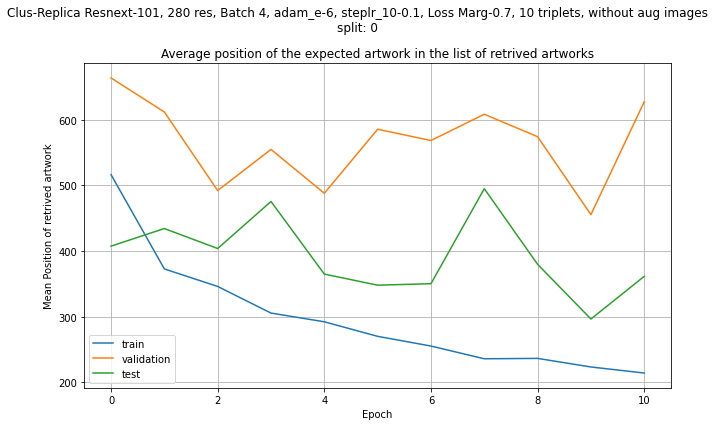

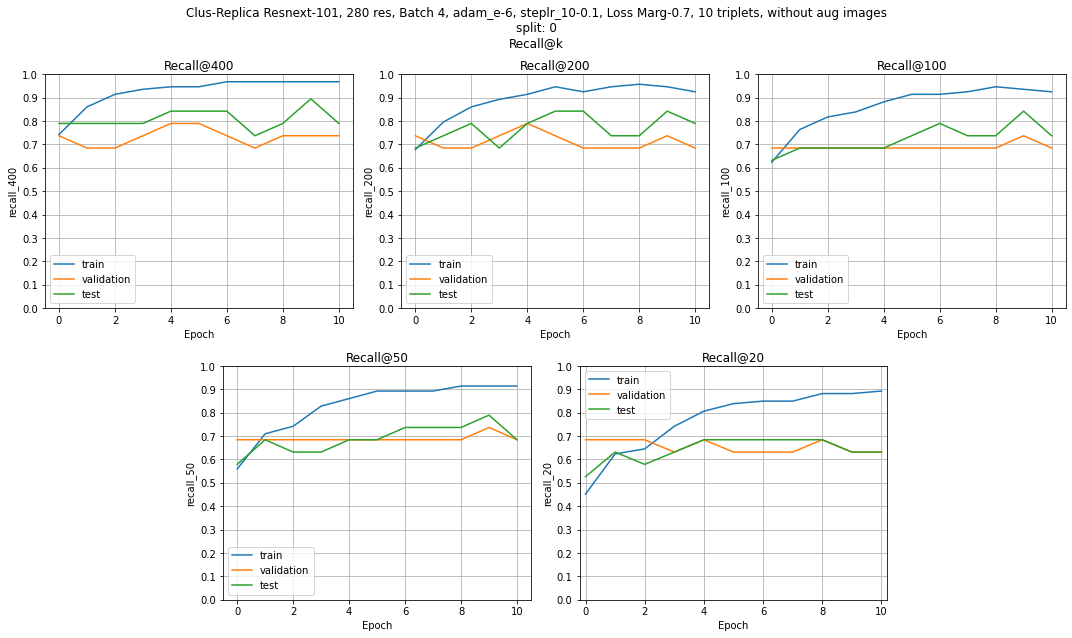

In [5]:
split_id = 0

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [6]:
best_epoch = 9

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v1

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,529.190476,512.950000,462.162500,0.391949,0.775000,0.712500,0.650000,0.600000,0.537500
1,405.476190,281.325000,346.687500,0.471319,0.837500,0.800000,0.750000,0.650000,0.587500
2,355.517857,224.187500,312.156250,0.483043,0.887500,0.825000,0.737500,0.662500,0.612500
3,310.458333,134.212500,257.931250,0.550577,0.925000,0.875000,0.837500,0.787500,0.725000
4,289.178571,133.500000,257.825000,0.548027,0.925000,0.900000,0.850000,0.825000,0.675000
5,262.755952,92.812500,236.531250,0.621666,0.950000,0.937500,0.900000,0.812500,0.787500
6,238.500000,62.500000,221.400000,0.664138,0.937500,0.925000,0.900000,0.887500,0.837500
7,220.702381,29.225000,205.037500,0.723380,0.962500,0.937500,0.925000,0.912500,0.850000
8,213.696429,31.562500,205.906250,0.676950,0.962500,0.950000,0.950000,0.900000,0.862500
9,226.339286,56.437500,218.368750,0.708460,0.962500,0.950000,0.937500,0.887500,0.825000


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,422.200000,444.400000,422.200000,0.235071,0.700000,0.633333,0.600000,0.533333,0.400000
1,357.183333,314.366667,357.183333,0.271257,0.800000,0.700000,0.700000,0.600000,0.466667
2,364.883333,329.766667,364.883333,0.243027,0.800000,0.733333,0.666667,0.633333,0.466667
3,374.133333,348.266667,374.133333,0.256272,0.766667,0.733333,0.700000,0.566667,0.500000
4,413.883333,427.766667,413.883333,0.252477,0.800000,0.733333,0.633333,0.533333,0.433333
5,378.950000,357.900000,378.950000,0.269700,0.833333,0.766667,0.733333,0.700000,0.433333
6,423.333333,446.666667,423.333333,0.260433,0.766667,0.733333,0.666667,0.633333,0.466667
7,413.333333,426.666667,413.333333,0.240607,0.800000,0.733333,0.700000,0.666667,0.566667
8,439.533333,479.066667,439.533333,0.195895,0.733333,0.733333,0.633333,0.600000,0.466667
9,419.916667,439.833333,419.916667,0.221650,0.766667,0.733333,0.600000,0.600000,0.500000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,637.357143,874.714286,637.357143,0.261836,0.714286,0.666667,0.619048,0.571429,0.476190
1,663.261905,926.523810,663.261905,0.306801,0.714286,0.714286,0.666667,0.571429,0.523810
2,565.785714,731.571429,565.785714,0.272090,0.809524,0.761905,0.714286,0.666667,0.523810
3,569.404762,738.809524,569.404762,0.278236,0.761905,0.714286,0.714286,0.666667,0.476190
4,563.809524,727.619048,563.809524,0.290669,0.714286,0.714286,0.714286,0.619048,0.476190
5,639.952381,879.904762,639.952381,0.353606,0.761905,0.666667,0.666667,0.619048,0.476190
6,511.976190,623.952381,511.976190,0.379126,0.761905,0.714286,0.714286,0.714286,0.666667
7,521.571429,643.142857,521.571429,0.378827,0.714286,0.714286,0.714286,0.714286,0.619048
8,530.547619,661.095238,530.547619,0.336232,0.809524,0.761905,0.666667,0.666667,0.571429
9,480.238095,560.476190,480.238095,0.352470,0.761905,0.761905,0.714286,0.666667,0.476190


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,510.794118,621.588235,510.794118,0.246092,0.705882,0.647059,0.607843,0.549020,0.431373
1,483.215686,566.431373,483.215686,0.285892,0.764706,0.705882,0.686275,0.588235,0.490196
2,447.607843,495.215686,447.607843,0.254994,0.803922,0.745098,0.686275,0.647059,0.490196
3,454.539216,509.078431,454.539216,0.265316,0.764706,0.725490,0.705882,0.607843,0.490196
4,475.617647,551.235294,475.617647,0.268203,0.764706,0.725490,0.666667,0.568627,0.450980
5,486.421569,572.843137,486.421569,0.304250,0.803922,0.725490,0.705882,0.666667,0.450980
6,459.833333,519.666667,459.833333,0.309307,0.764706,0.725490,0.686275,0.666667,0.549020
7,457.901961,515.803922,457.901961,0.297521,0.764706,0.725490,0.705882,0.686275,0.588235
8,477.009804,554.019608,477.009804,0.253681,0.764706,0.745098,0.647059,0.627451,0.509804
9,444.754902,489.509804,444.754902,0.275517,0.764706,0.745098,0.647059,0.627451,0.490196


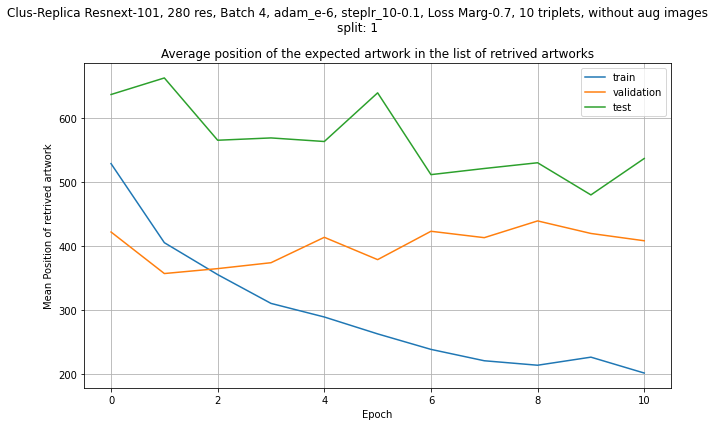

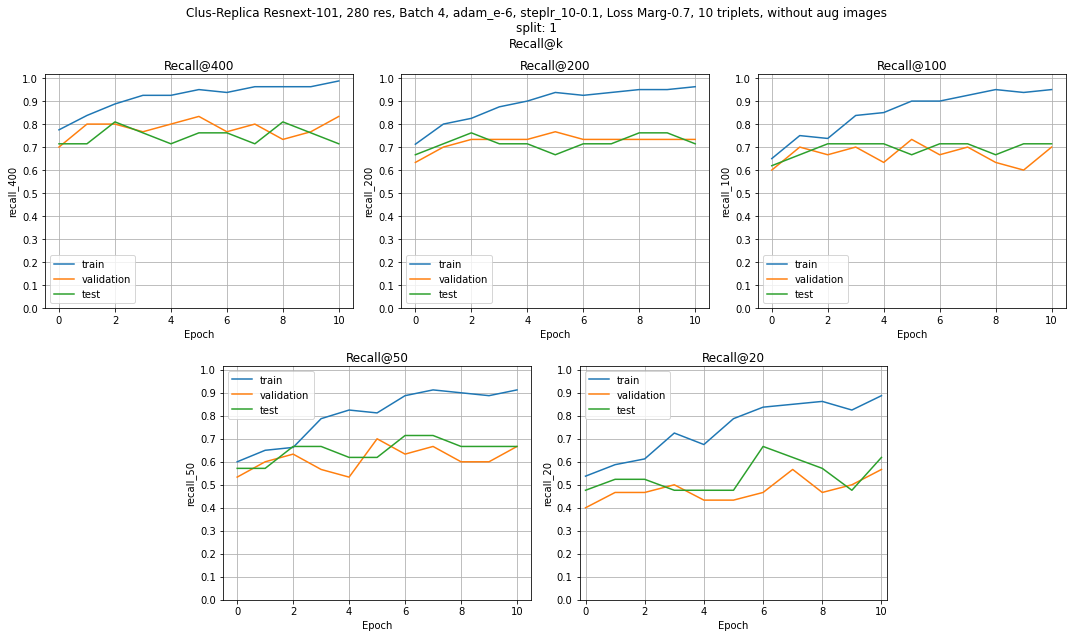

In [7]:
split_id = 1

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [8]:
best_epoch = 7

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v2

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,510.164706,512.024390,456.951220,0.400829,0.792683,0.731707,0.695122,0.646341,0.585366
1,409.676471,310.817073,360.286585,0.490131,0.829268,0.804878,0.768293,0.719512,0.670732
2,330.376471,188.195122,290.707317,0.542930,0.890244,0.853659,0.829268,0.780488,0.719512
3,317.411765,157.439024,274.207317,0.606981,0.914634,0.902439,0.829268,0.792683,0.743902
4,284.147059,76.841463,234.408537,0.669293,0.926829,0.902439,0.890244,0.878049,0.817073
5,253.952941,39.317073,214.853659,0.715710,0.975610,0.939024,0.926829,0.865854,0.853659
6,240.841176,40.012195,215.347561,0.723725,0.951220,0.951220,0.926829,0.902439,0.878049
7,231.294118,31.609756,210.975610,0.762145,0.963415,0.926829,0.926829,0.902439,0.865854
8,214.941176,26.975610,208.658537,0.792695,0.963415,0.963415,0.914634,0.914634,0.878049
9,211.711765,18.646341,204.493902,0.797143,0.975610,0.975610,0.951220,0.926829,0.902439


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,651.590909,903.181818,651.590909,0.244986,0.681818,0.590909,0.500000,0.454545,0.318182
1,635.227273,870.454545,635.227273,0.344333,0.772727,0.681818,0.545455,0.500000,0.454545
2,589.772727,779.545455,589.772727,0.287350,0.772727,0.772727,0.590909,0.500000,0.454545
3,591.500000,783.000000,591.500000,0.322618,0.818182,0.681818,0.590909,0.545455,0.454545
4,620.477273,840.954545,620.477273,0.264249,0.772727,0.727273,0.545455,0.454545,0.454545
5,536.590909,673.181818,536.590909,0.315608,0.772727,0.772727,0.636364,0.454545,0.454545
6,611.840909,823.681818,611.840909,0.355195,0.772727,0.681818,0.590909,0.545455,0.454545
7,628.409091,856.818182,628.409091,0.327678,0.772727,0.727273,0.590909,0.500000,0.454545
8,550.431818,700.863636,550.431818,0.251600,0.772727,0.727273,0.636364,0.500000,0.409091
9,611.454545,822.909091,611.454545,0.281101,0.727273,0.681818,0.636364,0.500000,0.409091


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,457.267857,403.000000,415.500000,0.209221,0.666667,0.629630,0.555556,0.481481,0.370370
1,314.553571,249.148148,313.018519,0.209028,0.814815,0.703704,0.666667,0.629630,0.444444
2,334.250000,267.851852,344.518519,0.194778,0.740741,0.666667,0.666667,0.555556,0.370370
3,368.142857,362.592593,367.444444,0.231741,0.777778,0.666667,0.666667,0.629630,0.518519
4,351.000000,322.074074,352.148148,0.243195,0.740741,0.703704,0.703704,0.555556,0.444444
5,375.464286,359.037037,384.407407,0.186903,0.777778,0.666667,0.592593,0.518519,0.370370
6,387.946429,397.444444,391.092593,0.207605,0.740741,0.703704,0.666667,0.481481,0.481481
7,451.535714,531.481481,455.962963,0.193189,0.740741,0.629630,0.555556,0.481481,0.370370
8,406.964286,426.518519,416.000000,0.220768,0.740741,0.629630,0.555556,0.518519,0.407407
9,415.946429,456.259259,419.759259,0.205785,0.740741,0.703704,0.629630,0.518519,0.333333


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,542.770000,627.571429,521.500000,0.225279,0.673469,0.612245,0.530612,0.469388,0.346939
1,455.650000,528.102041,457.683673,0.269777,0.795918,0.693878,0.612245,0.571429,0.448980
2,446.680000,497.591837,454.632653,0.236341,0.755102,0.714286,0.632653,0.530612,0.408163
3,466.420000,551.346939,468.040816,0.272543,0.795918,0.673469,0.632653,0.591837,0.489796
4,469.570000,555.040816,472.622449,0.252648,0.755102,0.714286,0.632653,0.510204,0.448980
5,446.360000,500.081633,452.734694,0.244689,0.775510,0.714286,0.612245,0.489796,0.408163
6,486.460000,588.816327,490.204082,0.273870,0.755102,0.693878,0.632653,0.510204,0.469388
7,529.360000,677.551020,533.387755,0.253572,0.755102,0.673469,0.571429,0.489796,0.408163
8,470.090000,549.693878,476.357143,0.234611,0.755102,0.673469,0.591837,0.510204,0.408163
9,501.970000,620.877551,505.826531,0.239600,0.734694,0.693878,0.632653,0.510204,0.367347


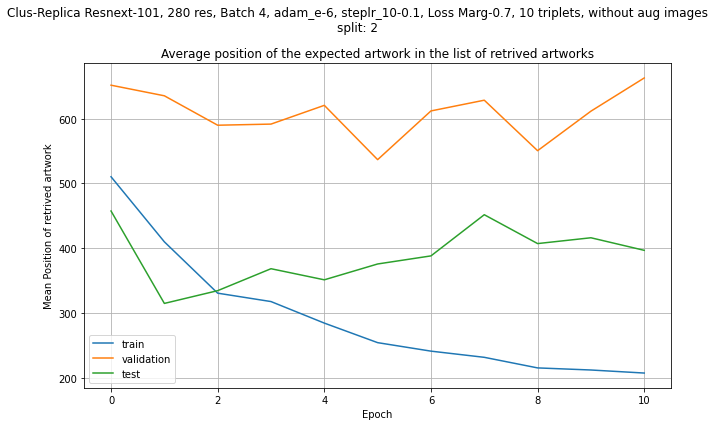

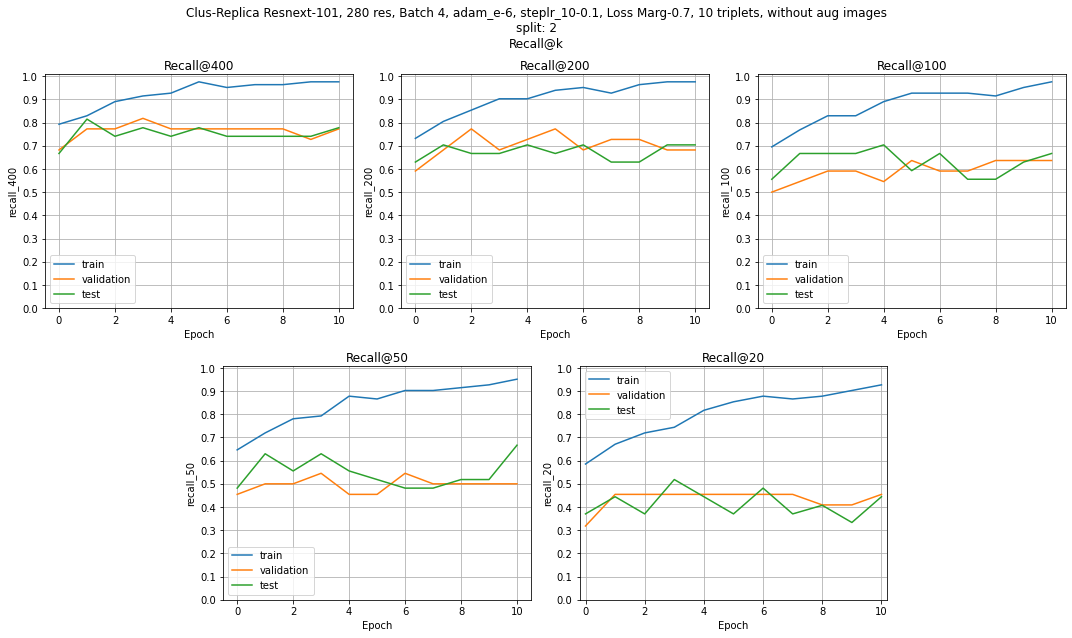

In [9]:
split_id = 2

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [10]:
best_epoch = 5

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v3

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,463.230769,538.389610,464.103896,0.416947,0.805195,0.753247,0.714286,0.675325,0.623377
1,330.147436,268.818182,329.266234,0.531738,0.870130,0.805195,0.792208,0.753247,0.662338
2,290.705128,188.909091,289.311688,0.574347,0.935065,0.870130,0.831169,0.792208,0.727273
3,262.198718,131.000000,260.512987,0.611203,0.961039,0.935065,0.870130,0.805195,0.740260
4,246.371795,99.090909,244.402597,0.661923,0.961039,0.935065,0.857143,0.831169,0.792208
5,233.519231,73.077922,231.370130,0.706130,0.987013,0.948052,0.883117,0.870130,0.805195
6,219.602564,44.883117,217.272727,0.746368,0.974026,0.974026,0.935065,0.896104,0.870130
7,220.852564,47.415584,218.538961,0.760864,0.987013,0.974026,0.948052,0.922078,0.870130
8,215.839744,37.259740,213.461039,0.812754,0.987013,0.974026,0.961039,0.948052,0.883117
9,217.147436,39.909091,214.785714,0.800579,0.987013,0.987013,0.974026,0.948052,0.909091


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,493.283333,548.103448,486.982759,0.165422,0.620690,0.586207,0.482759,0.413793,0.275862
1,489.400000,576.344828,498.827586,0.181670,0.689655,0.551724,0.551724,0.448276,0.344828
2,437.716667,488.448276,446.982759,0.193212,0.689655,0.551724,0.551724,0.482759,0.344828
3,437.600000,488.413793,446.103448,0.210375,0.724138,0.620690,0.551724,0.482759,0.379310
4,517.433333,639.724138,531.655172,0.182145,0.586207,0.517241,0.482759,0.379310,0.344828
5,458.233333,500.827586,463.137931,0.192656,0.655172,0.620690,0.517241,0.448276,0.344828
6,482.683333,550.793103,488.879310,0.205737,0.620690,0.586207,0.517241,0.482759,0.344828
7,400.366667,407.655172,410.068966,0.187956,0.655172,0.551724,0.517241,0.482759,0.379310
8,411.883333,430.448276,422.982759,0.214859,0.689655,0.551724,0.517241,0.517241,0.344828
9,456.650000,503.551724,464.775862,0.181752,0.655172,0.586207,0.482759,0.448276,0.413793


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,724.888889,615.440000,526.600000,0.280179,0.720000,0.600000,0.560000,0.480000,0.360000
1,780.851852,749.120000,578.920000,0.353390,0.720000,0.680000,0.560000,0.520000,0.480000
2,792.666667,760.320000,594.280000,0.360010,0.760000,0.720000,0.600000,0.560000,0.480000
3,757.000000,651.840000,537.960000,0.375978,0.760000,0.680000,0.560000,0.520000,0.480000
4,687.888889,659.440000,532.800000,0.337741,0.720000,0.680000,0.600000,0.560000,0.440000
5,701.870370,579.240000,491.660000,0.370808,0.840000,0.760000,0.720000,0.640000,0.520000
6,717.222222,567.280000,495.200000,0.363157,0.800000,0.760000,0.560000,0.520000,0.480000
7,664.870370,558.040000,492.180000,0.388181,0.880000,0.720000,0.640000,0.560000,0.520000
8,656.462963,535.640000,482.180000,0.401654,0.880000,0.800000,0.680000,0.600000,0.520000
9,682.203704,629.160000,536.940000,0.379065,0.760000,0.680000,0.640000,0.560000,0.440000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,602.991228,579.277778,505.324074,0.218550,0.666667,0.592593,0.518519,0.444444,0.314815
1,627.456140,656.333333,535.907407,0.261170,0.703704,0.611111,0.555556,0.481481,0.407407
2,605.850877,614.314815,515.175926,0.270434,0.722222,0.629630,0.574074,0.518519,0.407407
3,588.894737,564.074074,488.629630,0.287043,0.740741,0.648148,0.555556,0.500000,0.425926
4,598.175439,648.851852,532.185185,0.254180,0.648148,0.592593,0.537037,0.462963,0.388889
5,573.640351,537.129630,476.342593,0.275134,0.740741,0.685185,0.611111,0.537037,0.425926
6,593.780702,558.425926,491.805556,0.278616,0.703704,0.666667,0.537037,0.500000,0.407407
7,525.657895,477.277778,448.083333,0.280653,0.759259,0.629630,0.574074,0.518519,0.444444
8,527.736842,479.148148,450.388889,0.301338,0.777778,0.666667,0.592593,0.555556,0.425926
9,563.491228,561.703704,498.185185,0.273101,0.703704,0.629630,0.555556,0.500000,0.425926


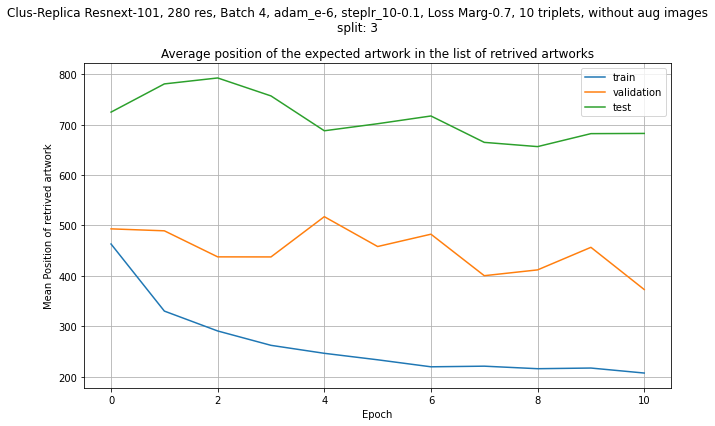

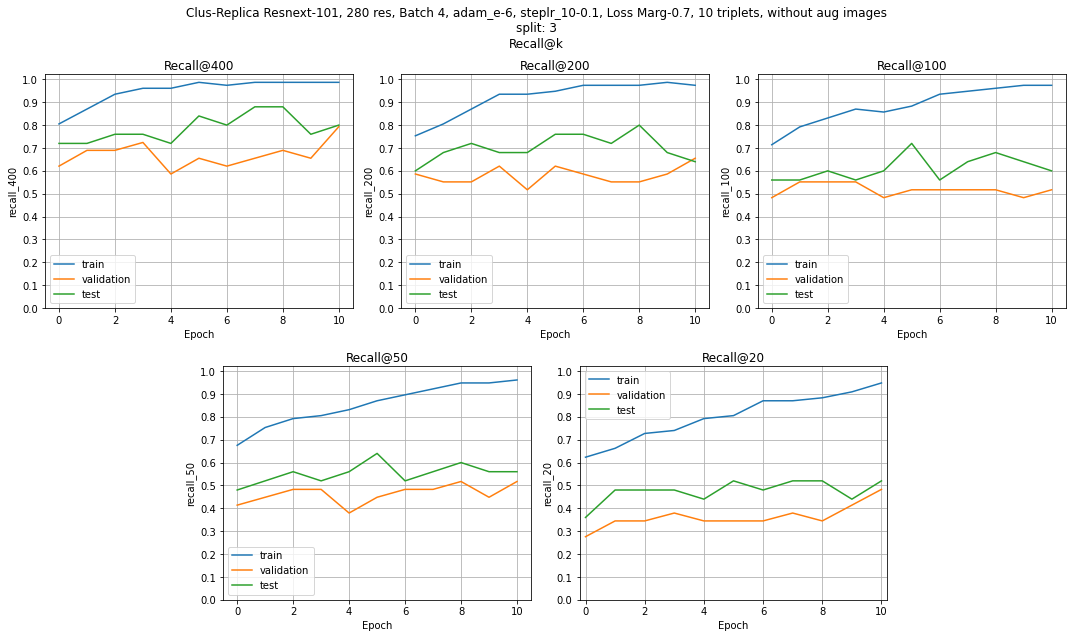

In [11]:
split_id = 3

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [12]:
best_epoch = 10

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v4

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,528.993976,562.629630,477.635802,0.406341,0.790123,0.716049,0.654321,0.617284,0.567901
1,437.759036,337.777778,369.222222,0.448041,0.864198,0.802469,0.740741,0.666667,0.617284
2,378.656627,233.197531,316.796296,0.546243,0.876543,0.802469,0.728395,0.691358,0.654321
3,318.072289,129.407407,264.777778,0.583940,0.913580,0.864198,0.827160,0.790123,0.753086
4,292.801205,111.592593,255.820988,0.638922,0.925926,0.888889,0.851852,0.814815,0.777778
5,277.409639,125.333333,262.679012,0.663836,0.950617,0.876543,0.839506,0.839506,0.802469
6,268.307229,103.765432,251.895062,0.707631,0.925926,0.913580,0.913580,0.876543,0.814815
7,230.837349,49.148148,224.598765,0.742579,0.962963,0.938272,0.938272,0.888889,0.839506
8,232.385542,59.456790,229.753086,0.757555,0.962963,0.938272,0.938272,0.925926,0.876543
9,226.644578,44.259259,222.154321,0.774655,0.962963,0.962963,0.938272,0.913580,0.876543


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,542.000000,589.266667,507.233333,0.177105,0.700000,0.633333,0.600000,0.500000,0.333333
1,485.419355,585.800000,496.966667,0.238356,0.833333,0.766667,0.700000,0.666667,0.433333
2,508.564516,650.766667,512.316667,0.202593,0.766667,0.766667,0.700000,0.600000,0.400000
3,445.693548,509.700000,452.916667,0.272843,0.766667,0.700000,0.666667,0.600000,0.433333
4,420.596774,457.766667,427.016667,0.275743,0.866667,0.800000,0.733333,0.600000,0.433333
5,463.645161,525.200000,475.933333,0.276757,0.800000,0.766667,0.666667,0.566667,0.466667
6,431.193548,475.400000,440.100000,0.286267,0.833333,0.766667,0.700000,0.566667,0.500000
7,443.112903,497.433333,453.716667,0.280561,0.833333,0.766667,0.733333,0.633333,0.533333
8,427.822581,435.633333,431.016667,0.249930,0.800000,0.733333,0.633333,0.633333,0.533333
9,425.241935,465.166667,432.883333,0.234115,0.800000,0.766667,0.700000,0.600000,0.500000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,466.380952,474.300000,455.900000,0.283993,0.650000,0.650000,0.600000,0.550000,0.450000
1,512.428571,658.100000,525.500000,0.380976,0.650000,0.600000,0.500000,0.500000,0.450000
2,633.523810,873.000000,651.600000,0.340141,0.550000,0.550000,0.500000,0.450000,0.450000
3,369.190476,360.900000,372.650000,0.304761,0.700000,0.650000,0.600000,0.550000,0.500000
4,403.333333,433.300000,405.600000,0.365346,0.750000,0.600000,0.550000,0.450000,0.450000
5,392.166667,392.050000,404.825000,0.314795,0.750000,0.650000,0.550000,0.500000,0.450000
6,414.309524,446.550000,426.575000,0.347149,0.850000,0.550000,0.500000,0.500000,0.500000
7,357.523810,343.400000,357.250000,0.352731,0.700000,0.650000,0.600000,0.550000,0.450000
8,412.809524,456.600000,417.900000,0.319467,0.700000,0.600000,0.550000,0.500000,0.500000
9,391.357143,383.250000,402.725000,0.330072,0.750000,0.650000,0.550000,0.500000,0.450000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,511.461538,543.280000,486.700000,0.219860,0.680000,0.640000,0.600000,0.520000,0.380000
1,496.326923,614.720000,508.380000,0.295404,0.760000,0.700000,0.620000,0.600000,0.440000
2,559.028846,739.660000,568.030000,0.257613,0.680000,0.680000,0.620000,0.540000,0.420000
3,414.798077,450.180000,420.810000,0.285610,0.740000,0.680000,0.640000,0.580000,0.460000
4,413.625000,447.980000,418.450000,0.311584,0.820000,0.720000,0.660000,0.540000,0.440000
5,434.778846,471.940000,447.490000,0.291972,0.780000,0.720000,0.620000,0.540000,0.460000
6,424.375000,463.860000,434.690000,0.310620,0.840000,0.680000,0.620000,0.540000,0.500000
7,408.548077,435.820000,415.130000,0.309429,0.780000,0.720000,0.680000,0.600000,0.500000
8,421.759615,444.020000,425.770000,0.277744,0.760000,0.680000,0.600000,0.580000,0.520000
9,411.557692,432.400000,420.820000,0.272498,0.780000,0.720000,0.640000,0.560000,0.480000


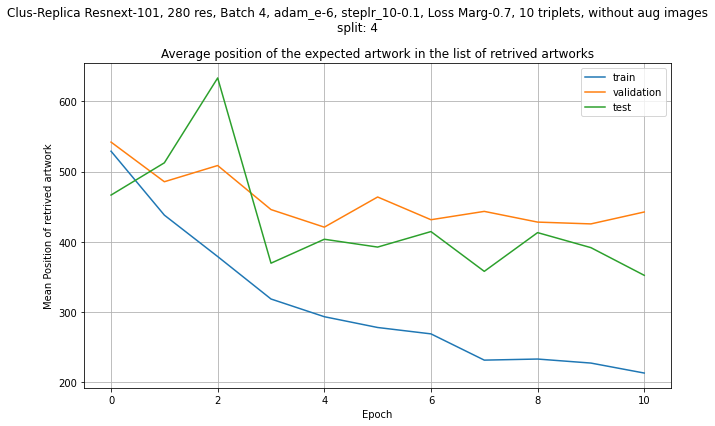

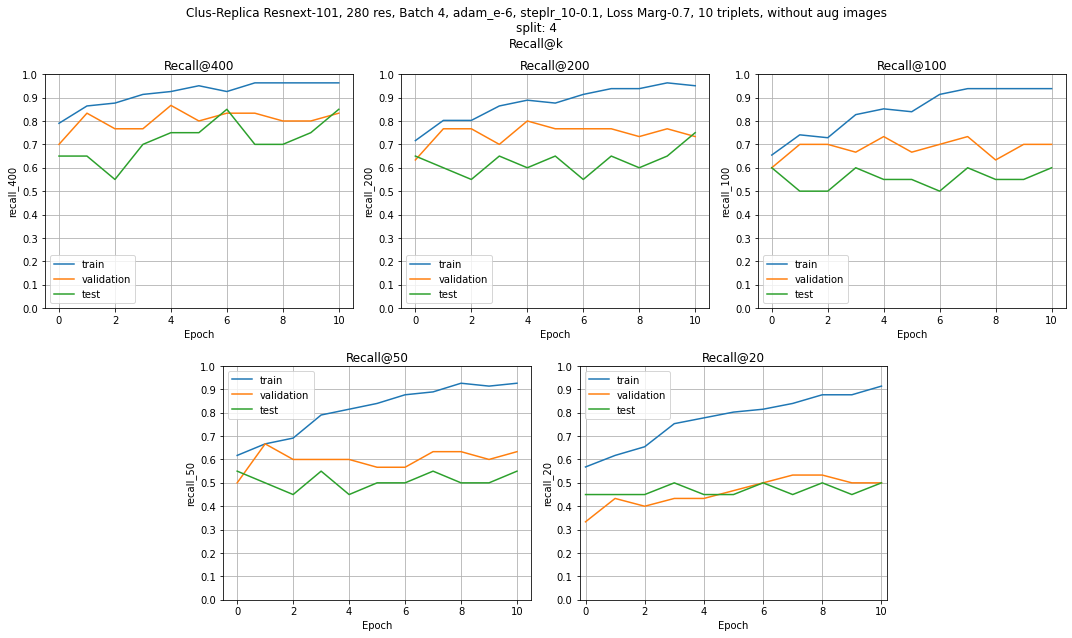

In [13]:
split_id = 4

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [14]:
best_epoch = 7

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v5

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,576.186047,650.144578,526.000000,0.358930,0.746988,0.710843,0.650602,0.602410,0.518072
1,444.534884,383.060241,396.301205,0.412561,0.819277,0.783133,0.771084,0.662651,0.566265
2,392.104651,261.325301,326.963855,0.459814,0.867470,0.843373,0.759036,0.722892,0.638554
3,327.686047,164.578313,277.915663,0.520250,0.915663,0.879518,0.843373,0.783133,0.698795
4,293.017442,130.349398,260.475904,0.574097,0.915663,0.891566,0.831325,0.795181,0.746988
5,285.965116,96.915663,243.734940,0.596392,0.927711,0.891566,0.867470,0.819277,0.795181
6,240.215116,52.638554,221.548193,0.665069,0.951807,0.951807,0.903614,0.843373,0.819277
7,248.093023,76.216867,233.337349,0.685583,0.939759,0.939759,0.927711,0.879518,0.819277
8,220.104651,38.216867,214.337349,0.717441,0.951807,0.951807,0.927711,0.915663,0.843373
9,221.215116,28.373494,209.415663,0.737370,0.963855,0.963855,0.951807,0.927711,0.855422


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,384.931034,369.862069,384.931034,0.236553,0.724138,0.655172,0.586207,0.482759,0.413793
1,359.827586,319.655172,359.827586,0.265712,0.827586,0.758621,0.655172,0.655172,0.517241
2,359.000000,318.000000,359.000000,0.284518,0.793103,0.793103,0.655172,0.655172,0.482759
3,297.672414,195.344828,297.672414,0.296843,0.862069,0.758621,0.689655,0.620690,0.551724
4,338.344828,276.689655,338.344828,0.277508,0.862069,0.758621,0.724138,0.620690,0.586207
5,368.741379,337.482759,368.741379,0.327386,0.862069,0.793103,0.655172,0.620690,0.551724
6,313.517241,227.034483,313.517241,0.318160,0.862069,0.793103,0.724138,0.724138,0.551724
7,308.379310,216.758621,308.379310,0.374428,0.896552,0.827586,0.793103,0.758621,0.620690
8,322.724138,245.448276,322.724138,0.347761,0.827586,0.827586,0.758621,0.689655,0.586207
9,287.844828,175.689655,287.844828,0.298150,0.862069,0.793103,0.689655,0.620690,0.517241


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,489.375000,423.631579,431.710526,0.381864,0.789474,0.631579,0.631579,0.631579,0.526316
1,361.100000,345.368421,366.473684,0.533596,0.842105,0.736842,0.631579,0.631579,0.578947
2,369.675000,272.052632,356.500000,0.403469,0.736842,0.736842,0.684211,0.631579,0.578947
3,327.450000,244.105263,343.105263,0.489053,0.736842,0.736842,0.684211,0.578947,0.578947
4,318.050000,240.631579,328.210526,0.481599,0.789474,0.736842,0.631579,0.631579,0.526316
5,378.700000,367.473684,392.421053,0.455944,0.789474,0.736842,0.684211,0.578947,0.526316
6,331.025000,273.315789,339.184211,0.508304,0.789474,0.736842,0.631579,0.631579,0.631579
7,273.725000,167.631579,271.394737,0.485378,0.789474,0.789474,0.736842,0.684211,0.578947
8,310.275000,231.526316,316.342105,0.477823,0.736842,0.684211,0.684211,0.684211,0.684211
9,301.325000,179.736842,310.868421,0.461861,0.894737,0.684211,0.684211,0.578947,0.578947


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,427.561224,391.145833,403.447917,0.294072,0.750000,0.645833,0.604167,0.541667,0.458333
1,360.346939,329.833333,362.458333,0.371749,0.833333,0.750000,0.645833,0.645833,0.541667
2,363.357143,299.812500,358.010417,0.331603,0.770833,0.770833,0.666667,0.645833,0.520833
3,309.826531,214.645833,315.656250,0.372926,0.812500,0.750000,0.687500,0.604167,0.562500
4,330.061224,262.416667,334.333333,0.358294,0.833333,0.750000,0.687500,0.625000,0.562500
5,372.806122,349.354167,378.114583,0.378273,0.833333,0.770833,0.666667,0.604167,0.541667
6,320.663265,245.354167,323.677083,0.393426,0.833333,0.770833,0.687500,0.687500,0.583333
7,294.234694,197.312500,293.739583,0.418346,0.854167,0.812500,0.770833,0.729167,0.604167
8,317.642857,239.937500,320.197917,0.399244,0.791667,0.770833,0.729167,0.687500,0.625000
9,293.346939,177.291667,296.958333,0.362952,0.875000,0.750000,0.687500,0.604167,0.541667


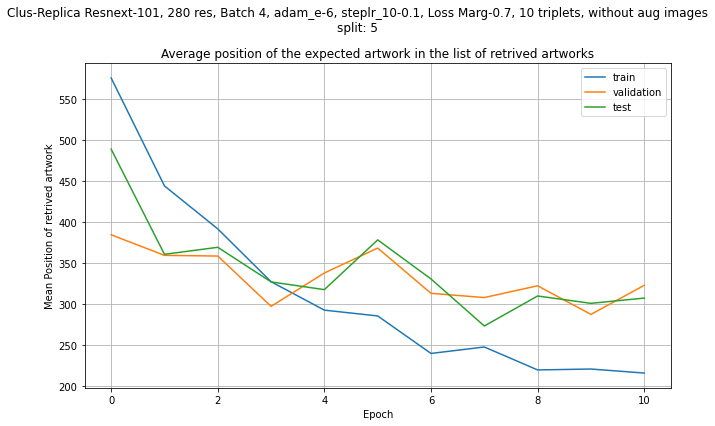

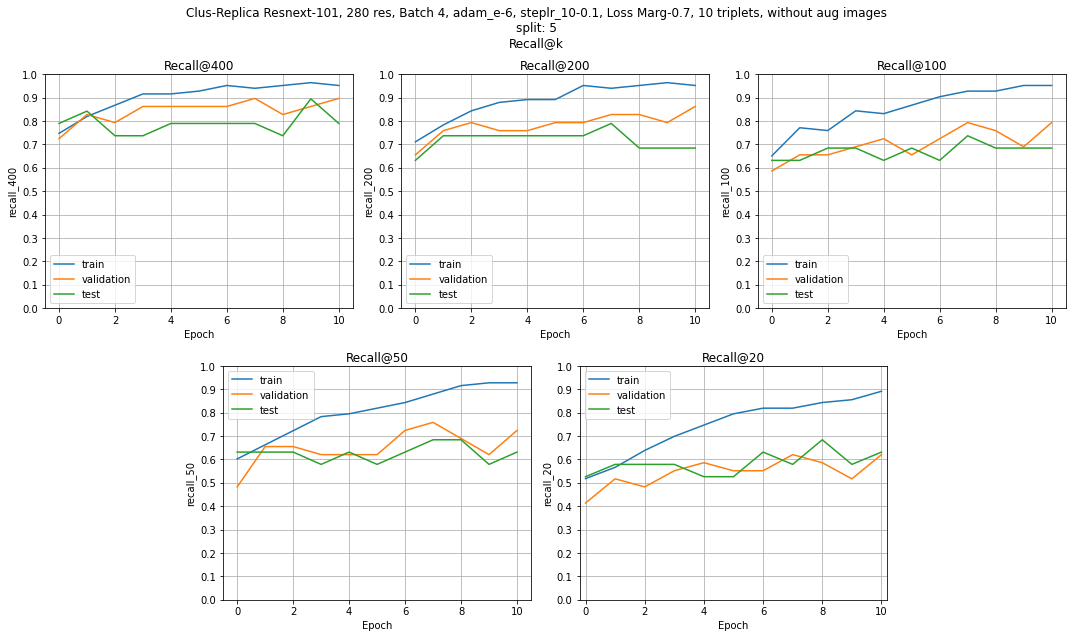

In [15]:
split_id = 5

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [16]:
best_epoch = 7

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v6

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,501.170732,552.050000,485.437500,0.389618,0.750000,0.725000,0.687500,0.650000,0.562500
1,386.396341,380.912500,391.118750,0.468571,0.862500,0.800000,0.737500,0.700000,0.612500
2,320.993902,254.887500,320.406250,0.539015,0.875000,0.837500,0.812500,0.762500,0.675000
3,257.609756,127.200000,254.400000,0.574689,0.912500,0.887500,0.850000,0.812500,0.762500
4,235.780488,82.300000,232.187500,0.601082,0.950000,0.925000,0.887500,0.812500,0.750000
5,227.810976,66.337500,223.843750,0.671072,0.962500,0.950000,0.875000,0.862500,0.800000
6,227.134146,65.325000,222.962500,0.676578,0.962500,0.937500,0.912500,0.900000,0.850000
7,208.207317,26.425000,203.612500,0.731308,0.987500,0.962500,0.950000,0.887500,0.862500
8,205.597561,21.000000,200.975000,0.737311,0.987500,0.987500,0.975000,0.912500,0.875000
9,202.859756,15.162500,198.281250,0.775755,0.987500,0.987500,0.975000,0.950000,0.900000


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,662.075000,524.611111,445.750000,0.260892,0.722222,0.555556,0.555556,0.555556,0.500000
1,706.750000,430.000000,415.388889,0.334741,0.666667,0.666667,0.555556,0.555556,0.555556
2,604.325000,309.722222,356.027778,0.290363,0.666667,0.666667,0.611111,0.555556,0.555556
3,651.000000,299.444444,352.166667,0.329767,0.666667,0.611111,0.611111,0.611111,0.555556
4,641.000000,283.000000,342.666667,0.314993,0.666667,0.666667,0.555556,0.555556,0.555556
5,576.800000,271.444444,335.944444,0.338315,0.666667,0.611111,0.611111,0.611111,0.555556
6,604.300000,259.888889,330.166667,0.331488,0.722222,0.611111,0.611111,0.611111,0.555556
7,632.075000,300.388889,351.361111,0.338925,0.722222,0.666667,0.611111,0.611111,0.555556
8,559.575000,235.055556,320.027778,0.268109,0.666667,0.666667,0.611111,0.611111,0.444444
9,631.050000,257.888889,329.388889,0.436971,0.722222,0.666667,0.666667,0.555556,0.555556


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,489.848485,579.696970,489.848485,0.243671,0.757576,0.666667,0.545455,0.424242,0.333333
1,447.924242,495.848485,447.924242,0.316887,0.818182,0.727273,0.666667,0.545455,0.515152
2,488.939394,577.878788,488.939394,0.311660,0.818182,0.696970,0.636364,0.575758,0.454545
3,461.666667,523.333333,461.666667,0.284427,0.787879,0.666667,0.545455,0.454545,0.424242
4,550.075758,700.151515,550.075758,0.327322,0.696970,0.666667,0.606061,0.515152,0.363636
5,477.833333,555.666667,477.833333,0.317036,0.818182,0.727273,0.666667,0.515152,0.393939
6,500.575758,601.151515,500.575758,0.297774,0.757576,0.666667,0.606061,0.545455,0.393939
7,496.590909,593.181818,496.590909,0.276666,0.757576,0.666667,0.606061,0.575758,0.393939
8,522.409091,644.818182,522.409091,0.260852,0.727273,0.666667,0.575758,0.515152,0.424242
9,575.924242,751.848485,575.924242,0.259213,0.696970,0.666667,0.606061,0.484848,0.363636


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,554.839623,560.254902,474.284314,0.249749,0.745098,0.627451,0.549020,0.470588,0.392157
1,545.594340,472.607843,436.441176,0.323189,0.764706,0.705882,0.627451,0.549020,0.529412
2,532.481132,483.235294,442.029412,0.304144,0.764706,0.686275,0.627451,0.568627,0.490196
3,533.113208,444.313725,423.019608,0.300429,0.745098,0.647059,0.568627,0.509804,0.470588
4,584.386792,552.921569,476.872549,0.322970,0.686275,0.666667,0.588235,0.529412,0.431373
5,515.179245,455.352941,427.754902,0.324546,0.764706,0.686275,0.647059,0.549020,0.450980
6,539.716981,480.705882,440.431373,0.309673,0.745098,0.647059,0.607843,0.568627,0.450980
7,547.716981,489.843137,445.333333,0.298640,0.745098,0.666667,0.607843,0.588235,0.450980
8,536.433962,500.196078,450.980392,0.263413,0.705882,0.666667,0.588235,0.549020,0.431373
9,596.726415,577.509804,488.911765,0.321951,0.705882,0.666667,0.627451,0.509804,0.431373


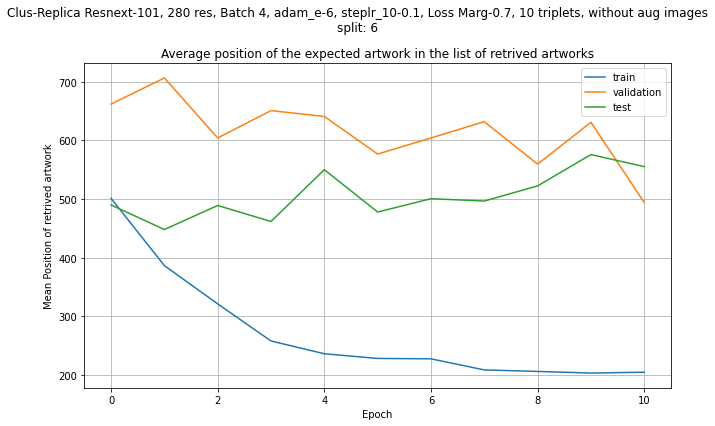

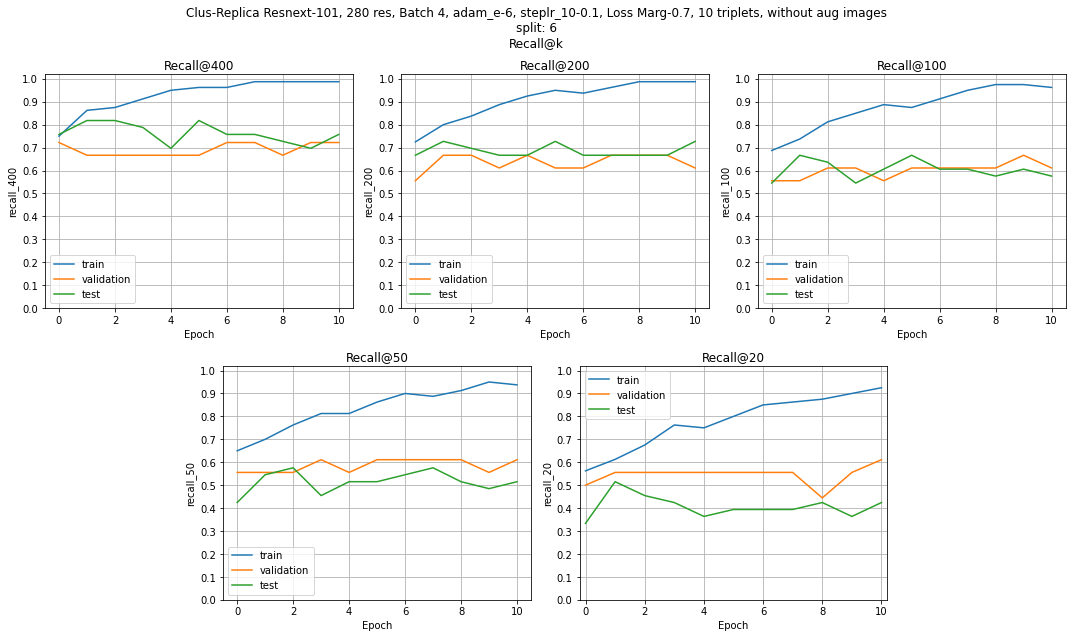

In [17]:
split_id = 6

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [18]:
best_epoch = 9

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v7

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,406.736842,366.150538,391.172043,0.330762,0.784946,0.731183,0.655914,0.591398,0.494624
1,311.515789,228.408602,313.129032,0.477898,0.870968,0.827957,0.784946,0.709677,0.645161
2,263.710526,136.483871,261.854839,0.546131,0.924731,0.903226,0.849462,0.774194,0.698925
3,239.163158,87.279570,236.370968,0.628314,0.967742,0.935484,0.903226,0.870968,0.784946
4,227.073684,62.602151,223.989247,0.635105,0.967742,0.935484,0.924731,0.849462,0.784946
5,230.652632,71.010753,227.107527,0.656561,0.967742,0.935484,0.924731,0.870968,0.838710
6,221.015789,50.204301,217.822581,0.678391,0.967742,0.924731,0.924731,0.870968,0.817204
7,209.410526,27.548387,205.440860,0.740579,0.989247,0.967742,0.967742,0.935484,0.903226
8,200.742105,10.032258,196.500000,0.791979,1.000000,0.978495,0.967742,0.956989,0.924731
9,212.352632,33.774194,208.349462,0.807969,0.967742,0.967742,0.967742,0.967742,0.946237


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,817.473684,1234.947368,817.473684,0.285107,0.578947,0.526316,0.526316,0.473684,0.421053
1,725.000000,1050.000000,725.000000,0.252754,0.526316,0.526316,0.526316,0.421053,0.368421
2,681.394737,962.789474,681.394737,0.233264,0.684211,0.578947,0.473684,0.473684,0.421053
3,642.078947,884.157895,642.078947,0.289721,0.736842,0.526316,0.473684,0.473684,0.368421
4,711.315789,1022.631579,711.315789,0.290023,0.684211,0.631579,0.473684,0.421053,0.421053
5,806.078947,1212.157895,806.078947,0.299141,0.631579,0.578947,0.473684,0.473684,0.368421
6,670.815789,941.631579,670.815789,0.258967,0.684211,0.578947,0.473684,0.421053,0.421053
7,747.000000,1094.000000,747.000000,0.306560,0.631579,0.578947,0.526316,0.473684,0.421053
8,757.789474,1115.578947,757.789474,0.306328,0.684211,0.526316,0.473684,0.421053,0.421053
9,651.000000,902.000000,651.000000,0.310290,0.684211,0.578947,0.578947,0.421053,0.421053


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,777.642857,801.105263,584.868421,0.406776,0.736842,0.631579,0.631579,0.631579,0.578947
1,736.142857,591.052632,498.736842,0.440863,0.789474,0.736842,0.736842,0.631579,0.578947
2,754.714286,557.368421,480.578947,0.450888,0.736842,0.736842,0.736842,0.684211,0.631579
3,713.595238,450.263158,432.815789,0.412232,0.736842,0.736842,0.736842,0.578947,0.578947
4,749.404762,542.578947,476.763158,0.445615,0.736842,0.736842,0.736842,0.684211,0.526316
5,640.309524,375.947368,393.921053,0.391946,0.736842,0.736842,0.684211,0.631579,0.631579
6,679.023810,540.578947,472.605263,0.360231,0.736842,0.736842,0.684211,0.684211,0.578947
7,691.452381,482.684211,443.973684,0.472220,0.736842,0.736842,0.736842,0.631579,0.526316
8,693.523810,620.000000,511.473684,0.363060,0.736842,0.736842,0.736842,0.736842,0.578947
9,705.666667,539.473684,470.789474,0.436745,0.736842,0.736842,0.736842,0.736842,0.631579


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,796.562500,1018.026316,701.171053,0.345942,0.657895,0.578947,0.578947,0.552632,0.500000
1,730.850000,820.526316,611.868421,0.346809,0.657895,0.631579,0.631579,0.526316,0.473684
2,719.887500,760.078947,580.986842,0.342076,0.710526,0.657895,0.605263,0.578947,0.526316
3,679.625000,667.210526,537.447368,0.350977,0.736842,0.631579,0.605263,0.526316,0.473684
4,731.312500,782.605263,594.039474,0.367819,0.710526,0.684211,0.605263,0.552632,0.473684
5,719.050000,794.052632,600.000000,0.345543,0.684211,0.657895,0.578947,0.552632,0.500000
6,675.125000,741.105263,571.710526,0.309599,0.710526,0.657895,0.578947,0.552632,0.500000
7,717.837500,788.342105,595.486842,0.389390,0.684211,0.657895,0.631579,0.552632,0.473684
8,724.050000,867.789474,634.631579,0.334694,0.710526,0.631579,0.605263,0.578947,0.500000
9,679.700000,720.736842,560.894737,0.373517,0.710526,0.657895,0.657895,0.578947,0.526316


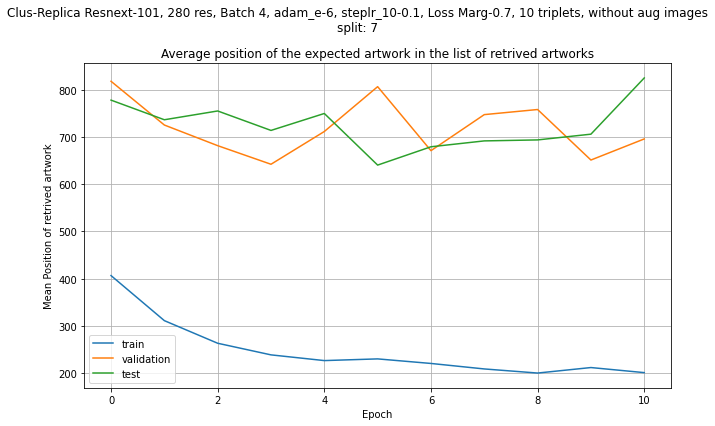

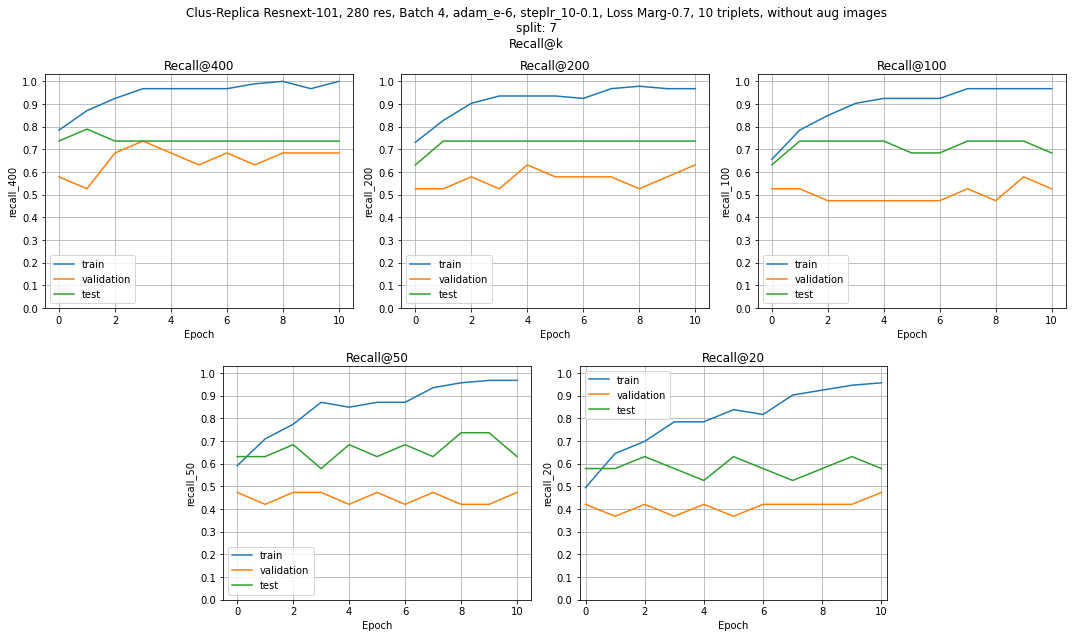

In [19]:
split_id = 7

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [20]:
best_epoch = 9

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v8

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,456.279070,472.819277,440.759036,0.381417,0.771084,0.746988,0.686747,0.638554,0.554217
1,345.720930,306.963855,347.493976,0.447273,0.831325,0.783133,0.710843,0.626506,0.614458
2,300.738372,221.240964,297.536145,0.494459,0.891566,0.819277,0.795181,0.674699,0.650602
3,242.215116,100.951807,236.981928,0.562573,0.963855,0.915663,0.867470,0.819277,0.759036
4,228.104651,72.289157,222.072289,0.575356,0.939759,0.903614,0.855422,0.807229,0.722892
5,212.575581,39.939759,206.090361,0.632684,0.951807,0.951807,0.915663,0.879518,0.807229
6,203.941860,22.337349,197.000000,0.669497,0.987952,0.963855,0.951807,0.891566,0.831325
7,197.802326,9.397590,190.746988,0.733079,1.000000,0.987952,0.975904,0.963855,0.903614
8,197.331395,8.807229,190.066265,0.745398,1.000000,0.987952,0.975904,0.951807,0.891566
9,196.761628,7.674699,189.451807,0.787225,1.000000,0.987952,0.987952,0.963855,0.927711


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,695.693548,710.033333,558.150000,0.199919,0.600000,0.500000,0.433333,0.366667,0.300000
1,736.016129,663.433333,544.883333,0.262536,0.633333,0.533333,0.533333,0.466667,0.366667
2,715.161290,652.600000,539.500000,0.226760,0.633333,0.566667,0.566667,0.533333,0.400000
3,621.774194,529.000000,477.600000,0.228694,0.666667,0.666667,0.533333,0.533333,0.366667
4,664.919355,527.900000,477.050000,0.228844,0.700000,0.566667,0.500000,0.466667,0.400000
5,624.532258,440.300000,433.383333,0.272700,0.766667,0.633333,0.600000,0.566667,0.533333
6,737.177419,659.300000,542.950000,0.257428,0.700000,0.633333,0.566667,0.533333,0.433333
7,646.774194,516.000000,471.266667,0.278243,0.700000,0.600000,0.566667,0.566667,0.400000
8,634.274194,481.500000,454.016667,0.281538,0.700000,0.633333,0.566667,0.533333,0.433333
9,606.387097,491.000000,458.633333,0.290128,0.700000,0.633333,0.566667,0.533333,0.433333


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,538.666667,677.333333,538.666667,0.347305,0.888889,0.722222,0.722222,0.666667,0.555556
1,612.388889,824.777778,612.388889,0.317606,0.777778,0.666667,0.611111,0.611111,0.500000
2,690.000000,980.000000,690.000000,0.322049,0.611111,0.611111,0.611111,0.611111,0.444444
3,508.305556,616.611111,508.305556,0.321601,0.777778,0.666667,0.666667,0.666667,0.444444
4,559.611111,719.222222,559.611111,0.335914,0.777778,0.666667,0.611111,0.611111,0.555556
5,504.944444,609.888889,504.944444,0.363047,0.833333,0.722222,0.666667,0.666667,0.555556
6,552.416667,704.833333,552.416667,0.291717,0.833333,0.611111,0.611111,0.611111,0.500000
7,600.277778,800.555556,600.277778,0.360275,0.777778,0.666667,0.666667,0.611111,0.500000
8,544.805556,689.611111,544.805556,0.249583,0.833333,0.666667,0.611111,0.611111,0.444444
9,544.138889,688.277778,544.138889,0.312039,0.777778,0.722222,0.666667,0.666667,0.555556


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,638.010204,697.770833,550.843750,0.255189,0.708333,0.583333,0.541667,0.479167,0.395833
1,690.602041,723.937500,570.197917,0.283187,0.687500,0.583333,0.562500,0.520833,0.416667
2,705.918367,775.375000,595.937500,0.262493,0.625000,0.583333,0.583333,0.562500,0.416667
3,580.091837,561.854167,489.114583,0.263534,0.708333,0.666667,0.583333,0.583333,0.395833
4,626.234694,599.645833,508.010417,0.268995,0.729167,0.604167,0.541667,0.520833,0.458333
5,580.602041,503.895833,460.218750,0.306580,0.791667,0.666667,0.625000,0.604167,0.541667
6,669.306122,676.375000,546.500000,0.270286,0.750000,0.625000,0.583333,0.562500,0.458333
7,629.693878,622.708333,519.645833,0.309005,0.729167,0.625000,0.604167,0.583333,0.437500
8,601.408163,559.541667,488.062500,0.269555,0.750000,0.645833,0.583333,0.562500,0.437500
9,583.520408,564.979167,490.697917,0.298345,0.729167,0.666667,0.604167,0.583333,0.479167


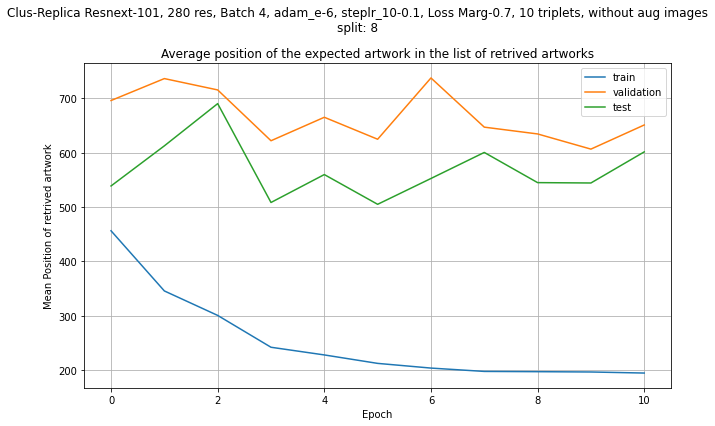

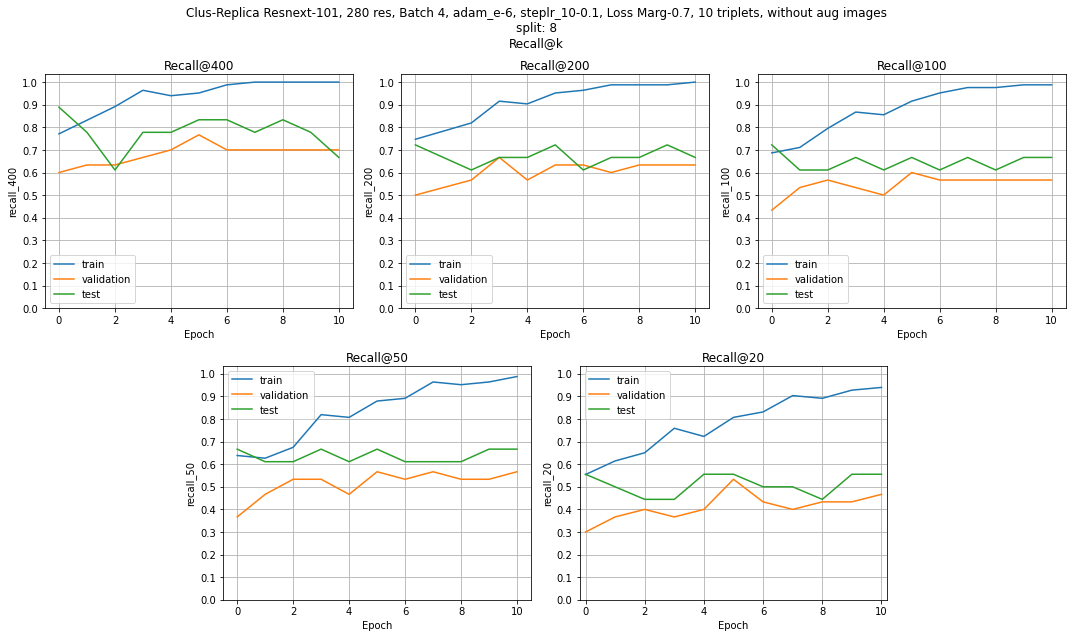

In [21]:
split_id = 8

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [22]:
best_epoch = 5

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v9

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,559.150000,599.604167,504.541667,0.324109,0.718750,0.677083,0.625000,0.562500,0.489583
1,418.720000,347.937500,370.906250,0.434228,0.854167,0.812500,0.760417,0.687500,0.583333
2,386.250000,271.416667,329.437500,0.512167,0.875000,0.854167,0.812500,0.729167,0.635417
3,333.425000,178.343750,281.953125,0.535995,0.875000,0.854167,0.822917,0.781250,0.687500
4,300.650000,132.583333,258.583333,0.625065,0.906250,0.875000,0.864583,0.843750,0.791667
5,266.555000,103.739583,243.671875,0.633131,0.927083,0.895833,0.885417,0.864583,0.791667
6,256.405000,74.614583,229.317708,0.619008,0.927083,0.906250,0.875000,0.875000,0.822917
7,233.255000,45.385417,214.588542,0.690191,0.968750,0.947917,0.916667,0.895833,0.875000
8,241.110000,61.208333,222.500000,0.718831,0.958333,0.958333,0.895833,0.895833,0.885417
9,225.975000,49.635417,216.598958,0.744283,0.968750,0.947917,0.937500,0.906250,0.875000


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,522.578947,645.157895,522.578947,0.342137,0.736842,0.631579,0.578947,0.578947,0.421053
1,461.289474,522.578947,461.289474,0.350117,0.684211,0.526316,0.526316,0.526316,0.421053
2,495.500000,591.000000,495.500000,0.253413,0.684211,0.631579,0.578947,0.578947,0.473684
3,442.657895,485.315789,442.657895,0.325634,0.631579,0.631579,0.578947,0.526316,0.421053
4,409.184211,418.368421,409.184211,0.289097,0.736842,0.631579,0.631579,0.578947,0.526316
5,464.184211,528.368421,464.184211,0.330129,0.736842,0.736842,0.631579,0.526316,0.473684
6,343.473684,286.947368,343.473684,0.354544,0.736842,0.684211,0.526316,0.526316,0.526316
7,416.973684,433.947368,416.973684,0.307455,0.736842,0.684211,0.631579,0.578947,0.578947
8,426.473684,452.947368,426.473684,0.277264,0.736842,0.631579,0.578947,0.578947,0.526316
9,425.605263,451.210526,425.605263,0.394443,0.736842,0.684211,0.578947,0.578947,0.526316


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,291.156250,182.312500,291.156250,0.393222,0.937500,0.812500,0.750000,0.687500,0.625000
1,224.156250,48.312500,224.156250,0.441075,1.000000,0.875000,0.875000,0.750000,0.687500
2,255.781250,111.562500,255.781250,0.493323,0.937500,0.875000,0.875000,0.812500,0.687500
3,241.875000,83.750000,241.875000,0.432426,0.937500,0.875000,0.875000,0.812500,0.750000
4,267.750000,135.500000,267.750000,0.465900,0.937500,0.937500,0.937500,0.812500,0.750000
5,245.500000,91.000000,245.500000,0.436513,0.937500,0.875000,0.812500,0.750000,0.687500
6,242.937500,85.875000,242.937500,0.459811,0.937500,0.875000,0.875000,0.812500,0.687500
7,255.937500,111.875000,255.937500,0.514364,0.937500,0.875000,0.812500,0.750000,0.750000
8,314.156250,228.312500,314.156250,0.442107,0.937500,0.875000,0.812500,0.750000,0.625000
9,298.781250,197.562500,298.781250,0.500644,0.875000,0.812500,0.812500,0.750000,0.750000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,416.785714,433.571429,416.785714,0.365490,0.828571,0.714286,0.657143,0.628571,0.514286
1,352.885714,305.771429,352.885714,0.391698,0.828571,0.685714,0.685714,0.628571,0.542857
2,385.914286,371.828571,385.914286,0.363086,0.800000,0.742857,0.714286,0.685714,0.571429
3,350.871429,301.742857,350.871429,0.374453,0.771429,0.742857,0.714286,0.657143,0.571429
4,344.528571,289.057143,344.528571,0.369921,0.828571,0.771429,0.771429,0.685714,0.628571
5,364.214286,328.428571,364.214286,0.378762,0.828571,0.800000,0.714286,0.628571,0.571429
6,297.514286,195.028571,297.514286,0.402666,0.828571,0.771429,0.685714,0.657143,0.600000
7,343.357143,286.714286,343.357143,0.402042,0.828571,0.771429,0.714286,0.657143,0.657143
8,375.128571,350.257143,375.128571,0.352621,0.828571,0.742857,0.685714,0.657143,0.571429
9,367.628571,335.257143,367.628571,0.442992,0.800000,0.742857,0.685714,0.657143,0.628571


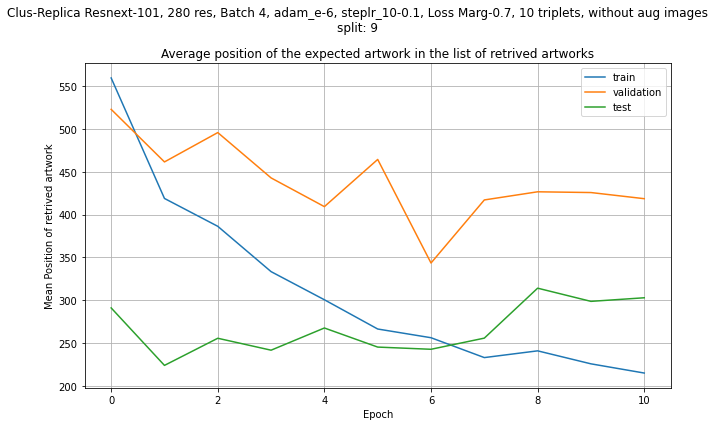

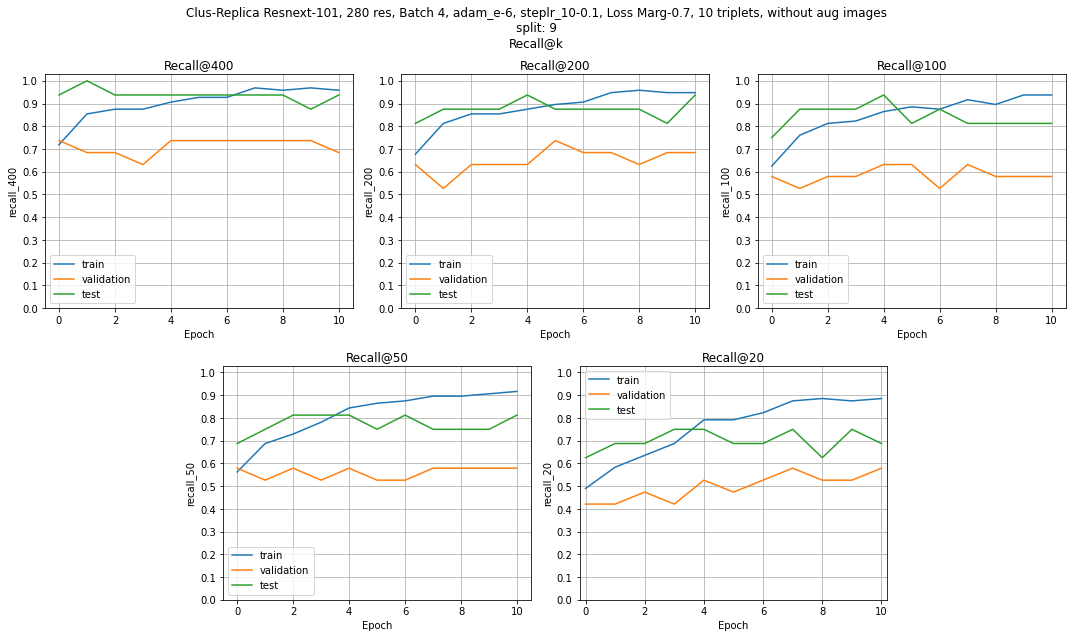

In [23]:
split_id = 9

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [24]:
best_epoch = 7

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v10

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,502.726316,498.752688,454.419355,0.299442,0.741935,0.677419,0.623656,0.569892,0.483871
1,397.210526,272.860215,343.225806,0.442530,0.881720,0.806452,0.709677,0.645161,0.612903
2,360.236842,200.333333,303.080645,0.520225,0.913978,0.849462,0.817204,0.774194,0.698925
3,305.878947,137.408602,270.704301,0.586534,0.935484,0.881720,0.860215,0.784946,0.731183
4,285.810526,124.021505,262.408602,0.674103,0.935484,0.913978,0.892473,0.838710,0.774194
5,274.278947,67.602151,233.865591,0.695194,0.946237,0.935484,0.924731,0.903226,0.817204
6,282.852632,113.247312,256.795699,0.708058,0.935484,0.924731,0.892473,0.860215,0.806452
7,231.984211,55.236559,227.725806,0.732586,0.967742,0.946237,0.935484,0.903226,0.849462
8,231.000000,58.086022,229.064516,0.783681,0.967742,0.946237,0.946237,0.903226,0.881720
9,238.315789,62.000000,231.032258,0.746095,0.956989,0.935484,0.935484,0.913978,0.881720


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,606.979167,745.500000,572.113636,0.369118,0.772727,0.727273,0.636364,0.545455,0.454545
1,395.208333,454.636364,398.590909,0.406766,0.772727,0.727273,0.681818,0.545455,0.545455
2,431.937500,438.590909,421.750000,0.386245,0.772727,0.727273,0.636364,0.500000,0.409091
3,485.833333,646.636364,500.318182,0.405271,0.772727,0.772727,0.636364,0.545455,0.545455
4,430.000000,498.727273,452.454545,0.418698,0.772727,0.681818,0.681818,0.681818,0.590909
5,415.916667,471.090909,435.409091,0.332036,0.772727,0.727273,0.727273,0.590909,0.590909
6,467.604167,554.318182,479.522727,0.429983,0.681818,0.681818,0.681818,0.636364,0.590909
7,331.916667,302.363636,336.590909,0.384283,0.818182,0.772727,0.681818,0.590909,0.545455
8,392.875000,430.181818,405.727273,0.397883,0.772727,0.727273,0.681818,0.681818,0.636364
9,420.750000,466.727273,435.954545,0.419877,0.727273,0.727273,0.727273,0.636364,0.590909


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,511.000000,622.000000,511.000000,0.496119,0.750000,0.687500,0.687500,0.687500,0.625000
1,554.062500,708.125000,554.062500,0.491903,0.687500,0.687500,0.687500,0.625000,0.562500
2,422.531250,445.062500,422.531250,0.419251,0.687500,0.687500,0.687500,0.687500,0.625000
3,535.687500,671.375000,535.687500,0.451578,0.687500,0.687500,0.687500,0.687500,0.625000
4,449.875000,499.750000,449.875000,0.486456,0.812500,0.750000,0.750000,0.750000,0.625000
5,370.375000,340.750000,370.375000,0.450084,0.750000,0.687500,0.687500,0.687500,0.687500
6,422.062500,444.125000,422.062500,0.456973,0.687500,0.687500,0.625000,0.625000,0.625000
7,418.937500,437.875000,418.937500,0.396066,0.812500,0.687500,0.687500,0.687500,0.625000
8,470.531250,541.062500,470.531250,0.489207,0.750000,0.687500,0.687500,0.687500,0.562500
9,361.500000,323.000000,361.500000,0.447310,0.812500,0.750000,0.687500,0.562500,0.562500


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,568.587500,693.500000,546.381579,0.422592,0.763158,0.710526,0.657895,0.605263,0.526316
1,458.750000,561.368421,464.052632,0.442613,0.736842,0.710526,0.684211,0.578947,0.552632
2,428.175000,441.315789,422.078947,0.400142,0.736842,0.710526,0.657895,0.578947,0.500000
3,505.775000,657.052632,515.210526,0.424769,0.736842,0.736842,0.657895,0.605263,0.578947
4,437.950000,499.157895,451.368421,0.447227,0.789474,0.710526,0.710526,0.710526,0.605263
5,397.700000,416.210526,408.026316,0.381741,0.763158,0.710526,0.710526,0.631579,0.631579
6,449.387500,507.921053,455.328947,0.441347,0.684211,0.684211,0.657895,0.631579,0.605263
7,366.725000,359.421053,371.263158,0.389244,0.815789,0.736842,0.684211,0.631579,0.578947
8,423.937500,476.868421,433.013158,0.436335,0.763158,0.710526,0.684211,0.684211,0.605263
9,397.050000,406.210526,404.605263,0.431428,0.763158,0.736842,0.710526,0.605263,0.578947


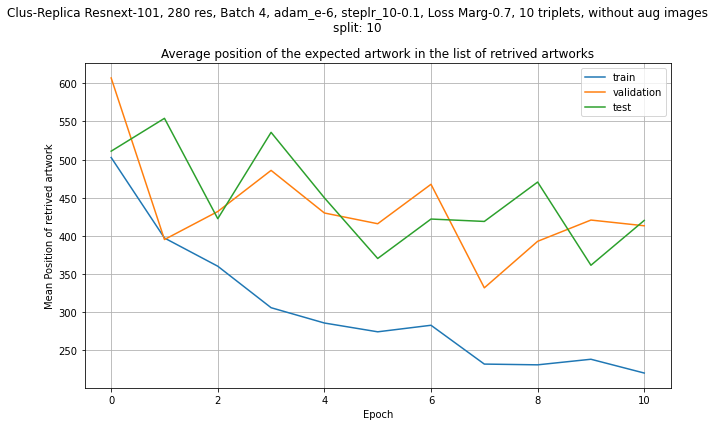

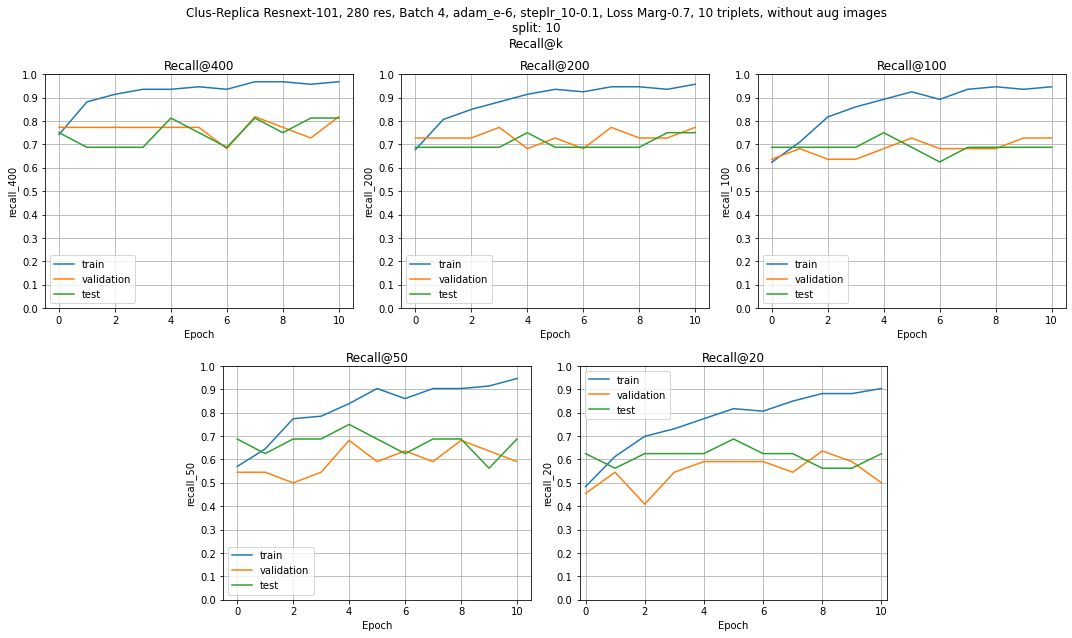

In [25]:
split_id = 10

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [26]:
best_epoch = 7

train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug Clus-Replica", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

In [27]:
train_metrics_df = pd.DataFrame(train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
val_metrics_df = pd.DataFrame(val_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
test_metrics_df = pd.DataFrame(test_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
non_train_metrics_df = pd.DataFrame(non_train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])

In [28]:
train_metrics_df["MAP"] = 100 * train_metrics_df["MAP"]
train_metrics_df["R@400"] = 100 * train_metrics_df["R@400"]
train_metrics_df["R@200"] = 100 * train_metrics_df["R@200"]
train_metrics_df["R@100"] = 100 * train_metrics_df["R@100"]
train_metrics_df["R@50"] = 100 * train_metrics_df["R@50"]
train_metrics_df["R@20"] = 100 * train_metrics_df["R@20"]

val_metrics_df["MAP"] = 100 * val_metrics_df["MAP"]
val_metrics_df["R@400"] = 100 * val_metrics_df["R@400"]
val_metrics_df["R@200"] = 100 * val_metrics_df["R@200"]
val_metrics_df["R@100"] = 100 * val_metrics_df["R@100"]
val_metrics_df["R@50"] = 100 * val_metrics_df["R@50"]
val_metrics_df["R@20"] = 100 * val_metrics_df["R@20"]

test_metrics_df["MAP"] = 100 * test_metrics_df["MAP"]
test_metrics_df["R@400"] = 100 * test_metrics_df["R@400"]
test_metrics_df["R@200"] = 100 * test_metrics_df["R@200"]
test_metrics_df["R@100"] = 100 * test_metrics_df["R@100"]
test_metrics_df["R@50"] = 100 * test_metrics_df["R@50"]
test_metrics_df["R@20"] = 100 * test_metrics_df["R@20"]

non_train_metrics_df["MAP"] = 100 * non_train_metrics_df["MAP"]
non_train_metrics_df["R@400"] = 100 * non_train_metrics_df["R@400"]
non_train_metrics_df["R@200"] = 100 * non_train_metrics_df["R@200"]
non_train_metrics_df["R@100"] = 100 * non_train_metrics_df["R@100"]
non_train_metrics_df["R@50"] = 100 * non_train_metrics_df["R@50"]
non_train_metrics_df["R@20"] = 100 * non_train_metrics_df["R@20"]

In [29]:
train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,0,9,223.242105,38.559140,219.322581,76.787243,96.774194,94.623656,93.548387,91.397849,88.172043
1,FT No-Aug Clus-Replica,1,7,220.702381,29.225000,205.037500,72.337967,96.250000,93.750000,92.500000,91.250000,85.000000
2,FT No-Aug Clus-Replica,2,5,253.952941,39.317073,214.853659,71.570988,97.560976,93.902439,92.682927,86.585366,85.365854
3,FT No-Aug Clus-Replica,3,10,207.224359,19.805195,204.733766,85.965873,98.701299,97.402597,97.402597,96.103896,94.805195
4,FT No-Aug Clus-Replica,4,7,230.837349,49.148148,224.598765,74.257935,96.296296,93.827160,93.827160,88.888889,83.950617
5,FT No-Aug Clus-Replica,5,7,248.093023,76.216867,233.337349,68.558255,93.975904,93.975904,92.771084,87.951807,81.927711
6,FT No-Aug Clus-Replica,6,9,202.859756,15.162500,198.281250,77.575548,98.750000,98.750000,97.500000,95.000000,90.000000
7,FT No-Aug Clus-Replica,7,9,212.352632,33.774194,208.349462,80.796904,96.774194,96.774194,96.774194,96.774194,94.623656
8,FT No-Aug Clus-Replica,8,5,212.575581,39.939759,206.090361,63.268419,95.180723,95.180723,91.566265,87.951807,80.722892
9,FT No-Aug Clus-Replica,9,7,233.255000,45.385417,214.588542,69.019062,96.875000,94.791667,91.666667,89.583333,87.500000


In [30]:
val_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,0,9,455.575000,556.894737,459.447368,29.153229,73.684211,73.684211,73.684211,73.684211,63.157895
1,FT No-Aug Clus-Replica,1,7,413.333333,426.666667,413.333333,24.060745,80.000000,73.333333,70.000000,66.666667,56.666667
2,FT No-Aug Clus-Replica,2,5,536.590909,673.181818,536.590909,31.560755,77.272727,77.272727,63.636364,45.454545,45.454545
3,FT No-Aug Clus-Replica,3,10,372.883333,361.965517,376.293103,24.138692,79.310345,65.517241,51.724138,51.724138,48.275862
4,FT No-Aug Clus-Replica,4,7,443.112903,497.433333,453.716667,28.056083,83.333333,76.666667,73.333333,63.333333,53.333333
5,FT No-Aug Clus-Replica,5,7,308.379310,216.758621,308.379310,37.442770,89.655172,82.758621,79.310345,75.862069,62.068966
6,FT No-Aug Clus-Replica,6,9,631.050000,257.888889,329.388889,43.697137,72.222222,66.666667,66.666667,55.555556,55.555556
7,FT No-Aug Clus-Replica,7,9,651.000000,902.000000,651.000000,31.028969,68.421053,57.894737,57.894737,42.105263,42.105263
8,FT No-Aug Clus-Replica,8,5,624.532258,440.300000,433.383333,27.269988,76.666667,63.333333,60.000000,56.666667,53.333333
9,FT No-Aug Clus-Replica,9,7,416.973684,433.947368,416.973684,30.745511,73.684211,68.421053,63.157895,57.894737,57.894737


In [31]:
test_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,0,9,296.375000,194.473684,305.657895,46.760319,89.473684,84.210526,84.210526,78.947368,63.157895
1,FT No-Aug Clus-Replica,1,7,521.571429,643.142857,521.571429,37.882650,71.428571,71.428571,71.428571,71.428571,61.904762
2,FT No-Aug Clus-Replica,2,5,375.464286,359.037037,384.407407,18.690290,77.777778,66.666667,59.259259,51.851852,37.037037
3,FT No-Aug Clus-Replica,3,10,682.592593,550.400000,506.960000,32.159525,80.000000,64.000000,60.000000,56.000000,52.000000
4,FT No-Aug Clus-Replica,4,7,357.523810,343.400000,357.250000,35.273120,70.000000,65.000000,60.000000,55.000000,45.000000
5,FT No-Aug Clus-Replica,5,7,273.725000,167.631579,271.394737,48.537831,78.947368,78.947368,73.684211,68.421053,57.894737
6,FT No-Aug Clus-Replica,6,9,575.924242,751.848485,575.924242,25.921303,69.696970,66.666667,60.606061,48.484848,36.363636
7,FT No-Aug Clus-Replica,7,9,705.666667,539.473684,470.789474,43.674489,73.684211,73.684211,73.684211,73.684211,63.157895
8,FT No-Aug Clus-Replica,8,5,504.944444,609.888889,504.944444,36.304717,83.333333,72.222222,66.666667,66.666667,55.555556
9,FT No-Aug Clus-Replica,9,7,255.937500,111.875000,255.937500,51.436372,93.750000,87.500000,81.250000,75.000000,75.000000


In [32]:
non_train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,0,9,375.975000,375.684211,382.552632,37.956774,81.578947,78.947368,78.947368,76.315789,63.157895
1,FT No-Aug Clus-Replica,1,7,457.901961,515.803922,457.901961,29.752118,76.470588,72.549020,70.588235,68.627451,58.823529
2,FT No-Aug Clus-Replica,2,5,446.360000,500.081633,452.734694,24.468866,77.551020,71.428571,61.224490,48.979592,40.816327
3,FT No-Aug Clus-Replica,3,10,519.587719,449.203704,436.787037,27.852040,79.629630,64.814815,55.555556,53.703704,50.000000
4,FT No-Aug Clus-Replica,4,7,408.548077,435.820000,415.130000,30.942898,78.000000,72.000000,68.000000,60.000000,50.000000
5,FT No-Aug Clus-Replica,5,7,294.234694,197.312500,293.739583,41.834565,85.416667,81.250000,77.083333,72.916667,60.416667
6,FT No-Aug Clus-Replica,6,9,596.726415,577.509804,488.911765,32.195126,70.588235,66.666667,62.745098,50.980392,43.137255
7,FT No-Aug Clus-Replica,7,9,679.700000,720.736842,560.894737,37.351729,71.052632,65.789474,65.789474,57.894737,52.631579
8,FT No-Aug Clus-Replica,8,5,580.602041,503.895833,460.218750,30.658012,79.166667,66.666667,62.500000,60.416667,54.166667
9,FT No-Aug Clus-Replica,9,7,343.357143,286.714286,343.357143,40.204190,82.857143,77.142857,71.428571,65.714286,65.714286


In [33]:
train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/train_scores_kfold.csv", index=False)
val_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/val_scores_kfold.csv", index=False)
test_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/test_scores_kfold.csv", index=False)
non_train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/non_train_scores_kfold.csv", index=False)

In [3]:
train_metrics_df= pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/train_scores_kfold.csv")
val_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/val_scores_kfold.csv")
test_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/test_scores_kfold.csv")
non_train_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_clusreplica_noaug/non_train_scores_kfold.csv")

In [4]:
get_averaged_df(train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,225.19 ± 16.32,40.16 ± 16.85,73.95 ± 6.24,96.72 ± 1.38,95.24 ± 1.67,93.98 ± 2.21,91.07 ± 3.47,87.0 ± 4.64


In [5]:
get_averaged_df(val_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,471.4 ± 121.89,460.85 ± 197.04,31.42 ± 6.14,77.82 ± 5.91,71.17 ± 7.4,66.14 ± 7.94,58.91 ± 10.57,53.85 ± 6.5


In [6]:
get_averaged_df(test_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug Clus-Replica,451.7 ± 158.38,428.1 ± 211.17,37.84 ± 9.83,79.03 ± 7.79,72.64 ± 7.85,69.05 ± 8.74,64.93 ± 10.33,55.42 ± 11.93
